# Spectral Fit using COSIpy Classic
This notebook performs a spectral fit on the Crab using simulated balloon flight data. By replacing the longitude, latitude, and name of the Crab in the fourth cell with that of another point source, you can do the spectral fit on Cen A, Cyg X-1, and Vela. 

In [1]:
from COSIpy import *
import response
from fit_simplified import *

Welcome to JupyROOT 6.24/06


/Users/eneights/software/COSItools/external/root_v6.24.06/lib/ROOT/_facade.py:150: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)


In [21]:
# Define simulated data and background & detector response filenames
data_dir = 'bootcamp_data'
filename = 'DC1_Combined.tra.gz'
response_filename = data_dir + '/Continuum_Response.npz'
background_filename = data_dir + '/Scaled_Ling_BG.npz'
background_mode = 'from file'

In [3]:
# Longitude & latitude of point sources
l_crab,b_crab = 184.55746, -5.78436 # Crab
l_cena,b_cena = 309.51584, 19.41709 # Cen A
l_cygx1,b_cygx1 = 71.334998, 3.06683 # Cyg X-1
l_vela,b_vela = 263.9390, -3.3683 # Vela

# Define time & energy bins
Delta_T = 7200 # Time bin size in seconds
energy_bin_edges = np.array([150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450, 5000]) # energy bins in keV

# Variable definitions
pixel_size = 6. # Pixel size in degrees
ul = 3 # SNR limit for upper limits on spectral fit

In [4]:
# Change this to the point source you want to run the spectral fit on
l,b = l_crab,b_crab
point_source = 'Crab'

In [5]:
# Read in simulated data (may take a few minutes)
analysis = COSIpy(data_dir,filename) # Create analysis object
analysis.read_COSI_DataSet() # Read in data

In [6]:
# Bin data
analysis.dataset.time_binning_tags(time_bin_size=Delta_T) # Time binning
analysis.dataset.init_binning(energy_bin_edges=energy_bin_edges,pixel_size=pixel_size) # Energy and pixel binning
analysis.dataset.get_binned_data() # Bin data

Loop over time bins:: 100%|█████████████████████| 297/297 [00:46<00:00,  6.36it/s]


In [7]:
# Print time binning information
print('Total time in dataset (s): ' + str(analysis.dataset.times.total_time))
print('Number of populated time bins: ' + str(analysis.dataset.times.n_ph))
print('Maximum time for each bin: ' + str(analysis.dataset.times.times_max))
print('Populated time bins: ' + str(analysis.dataset.times.n_ph_dx))
print('Number of counts in each time bin: ' + str(analysis.dataset.times.n_ph_t))

Total time in dataset (s): 2138399.198939562
Number of populated time bins: 297
Maximum time for each bin: [   7200.           14400.           21600.           28800.
   36000.           43200.           50400.           57600.
   64800.           72000.           79200.           86400.
   93600.          100800.          108000.          115200.
  122400.          129600.          136800.          144000.
  151200.          158400.          165600.          172800.
  180000.          187200.          194400.          201600.
  208800.          216000.          223200.          230400.
  237600.          244800.          252000.          259200.
  266400.          273600.          280800.          288000.
  295200.          302400.          309600.          316800.
  324000.          331200.          338400.          345600.
  352800.          360000.          367200.          374400.
  381600.          388800.          396000.          403200.
  410400.          417600.          424

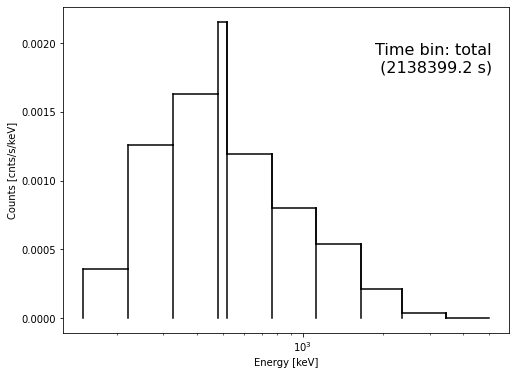

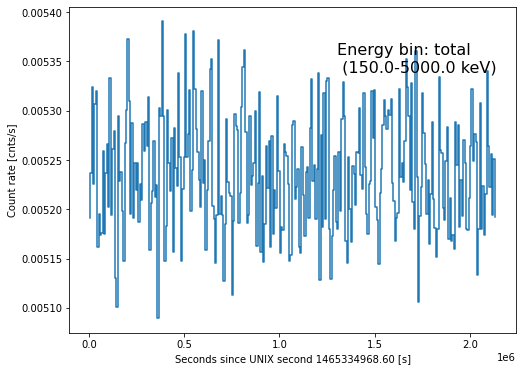

In [8]:
# Plot raw spectrum
analysis.dataset.plot_raw_spectrum()
plt.xscale('log')

# Plot light curve
analysis.dataset.plot_lightcurve()

In [9]:
# Define pointings (may take a few minutes)
pointing = Pointing(dataset=analysis.dataset)

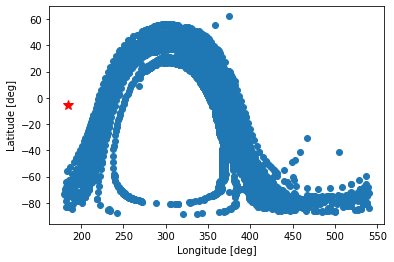

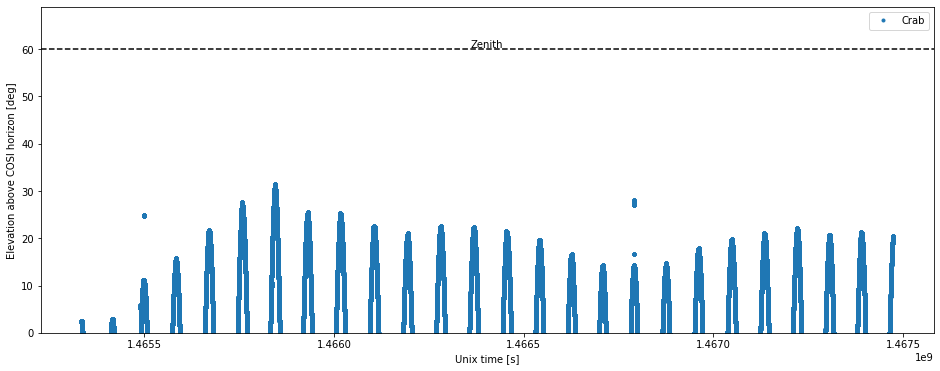

In [10]:
# Plot pointings
plt.plot(pointing.zpoins[:,0]+360,pointing.zpoins[:,1],'o')
plt.plot(l,b,'*r',markersize=10) # Plot point source location as a red star
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')

# Plot elevation of point source
analysis.plot_elevation([l],[b],[point_source])

In [11]:
# Read in background response
background = BG(dataset=analysis.dataset,mode=background_mode,filename=background_filename) # read in background

# Read in detector response (this takes a few minutes)
print('Reading in response...')
rsp = response.SkyResponse(filename=response_filename,pixel_size=pixel_size) # Read in response
rsp.calculate_PS_response(analysis.dataset,pointing,l,b,1,background=background,pixel_size=pixel_size,lookup=False) # Calculate point source response

Using background mode: from file
Reading in response...
Reading complete continuum response. This might take a while...
Done.

Creating general RMF matrices, stay tuned...


Loop over phi bins:: 100%|████████████████████████| 30/30 [00:33<00:00,  1.12s/it]


Done.

Creating general IRF. Wait for it...
Done.

Deleting full matrix.
Done. Now have fun.


Loop over pointings:: 100%|█████████████| 15117/15117 [00:00<00:00, 100070.22it/s]


In [12]:
# Print shape of response matrix (b, l, phi, fisbel, energy)
rsp.rsp.response_grid_normed_efinal.shape

(30, 60, 30, 1145, 10)

Text(0.5, 0, 'Time Bins')

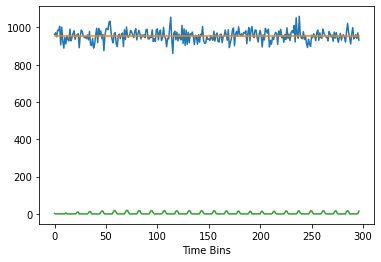

In [13]:
# For one energy bin, plot binned data light curve (blue), background model (orange), and sky model (green)
plt.plot(np.sum(analysis.dataset.binned_data[:,1,:,:],axis=(1,2)))
plt.plot(np.sum(background.bg_model_reduced[1],axis=1))
plt.plot(np.sum(rsp.sky_response[1],axis=1)*1000)
plt.xlabel('Time Bins')
# y-axis is counts/time bin for blue & orange, green curve is normalized to 1

In [15]:
# Spectral fit (this can take a few hours!)
result = fit(analysis.dataset,pointing,rsp,background) # Create fitting object
result.fit(iters=2000) # Perform spectral fit using emcee (uses pointing definition, background model, & point source response)

Loop over energy bins:: 100%|████████████████████| 10/10 [43:39<00:00, 261.96s/it]


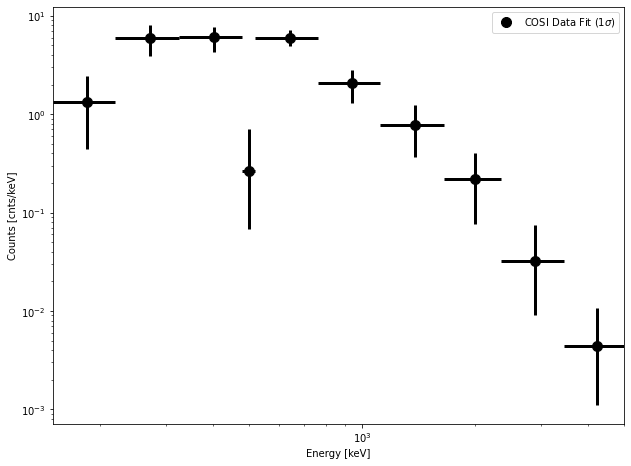

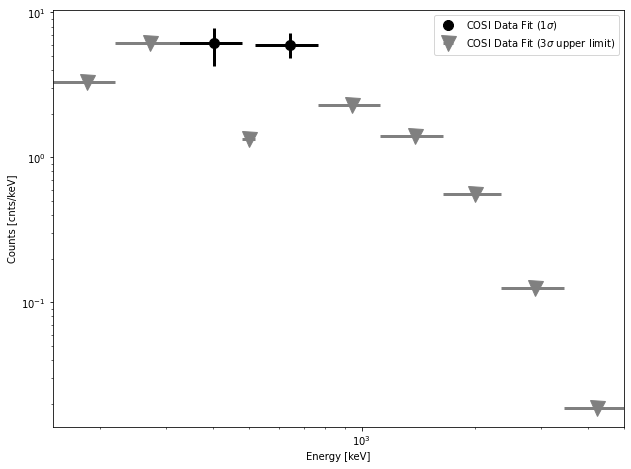

In [20]:
# Plot extracted spectrum of point source
result.plot_extracted_spectrum()
result.plot_extracted_spectrum(ul=ul)

In [17]:
# The simulated background used in this notebook is not time dependent
# If you are using a time dependent background model, you will need to use a tracer to define the variation of the background over time
# However, if your background is time dependent, you need to fit multiple background parameters, which is not currently possible with this fitting procedure
tracer = np.sum(analysis.dataset.binned_data,axis=(1,2,3)) # define tracer
tracer = tracer/np.mean(tracer)
background_tracer = BG(dataset=analysis.dataset,mode=background_mode,filename=background_filename,tracer=tracer) # read in background (with tracer)

Using background mode: from file


Text(0.5, 0, 'Time Bins')

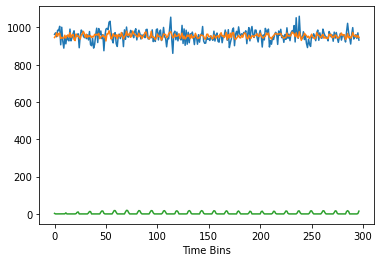

In [18]:
# For one energy bin, plot binned data light curve (blue), background model (orange), and sky model (green)
# The background response is no longer flat because it is now time dependent
plt.plot(np.sum(analysis.dataset.binned_data[:,1,:,:],axis=(1,2)))
plt.plot(np.sum(background_tracer.bg_model_reduced[1],axis=1))
plt.plot(np.sum(rsp.sky_response[1],axis=1)*1000)
plt.xlabel('Time Bins')